# This Notebook

In this notebook, we'll train a basic dense fully connected MLP as a baseline for our image classification.

# Importing Images

Let's set up some generators, since we won't be able to load all the images into memory, accessing the file structure built in the preprocessing notebook.

In [62]:
import datetime
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import layers
from keras import models
from keras import optimizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
image_root_dir = 'E:\LargeDatasets\SAR-Ocean-Images\GeoTIFF\OrganisationForModel'
train_dir = f'{image_root_dir}\\train'
val_dir = f'{image_root_dir}\\val'
test_dir = f'{image_root_dir}\\test'

Setting up generators...

In [4]:
batch_size = 8

train_generator = ImageDataGenerator().flow_from_directory(
        train_dir, class_mode = 'categorical', color_mode = 'grayscale',
        target_size=(540, 490), batch_size= batch_size)

val_generator = ImageDataGenerator().flow_from_directory(
        val_dir, class_mode = 'categorical', color_mode = 'grayscale',
        target_size=(540, 490), batch_size = batch_size)

test_generator = ImageDataGenerator().flow_from_directory(
        test_dir, class_mode = 'categorical', color_mode = 'grayscale',
        target_size=(540, 490), batch_size = batch_size, shuffle = False) 

Found 30041 images belonging to 10 classes.
Found 3756 images belonging to 10 classes.
Found 3756 images belonging to 10 classes.


## Verifying trainability of images

I was initially not able to get results, so I decided to investigate the image arrays to see what they looked like. Here I load one image..

In [5]:
image_path = 'E:\LargeDatasets\SAR-Ocean-Images\GeoTIFF\OrganisationForModel\\train\H\s1a-wv1-slc-vv-20160107t131721-20160107t131724-009388-00d975-029.tiff'
test_image = load_img(image_path, target_size = (540,490))

In [6]:
img_to_array(test_image)

array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 2

I immediately was able to notice that the pixel values were all a flat 255 for some reason, making it obvious the reason I was getting no results. Doing some google and stackexchange magic, I was able to determine that ImageDataGenerator.flow_from_directory() did not properly process 3 channel .tiff files and would compress Uint16 bits (range 0 to 65535) to Uint8 (range 0 to 255) resulting in nearly all the values being set to 255. A solution in the thread that was appropriate, as these were grayscale images anyway, was to set color_mode = 'grayscale' as above, resulting in single channel images with the proper pixel bit values as ddemonstrated below. 

In [4]:
train_generator[0]

(array([[[[ 7986.],
          [ 6488.],
          [ 4910.],
          ...,
          [ 5223.],
          [ 3850.],
          [ 7615.]],
 
         [[23903.],
          [19366.],
          [15383.],
          ...,
          [20469.],
          [16265.],
          [23816.]],
 
         [[27636.],
          [17294.],
          [16594.],
          ...,
          [18377.],
          [18977.],
          [34210.]],
 
         ...,
 
         [[32728.],
          [25338.],
          [26956.],
          ...,
          [24950.],
          [17589.],
          [25931.]],
 
         [[36948.],
          [22001.],
          [25313.],
          ...,
          [20552.],
          [20539.],
          [17045.]],
 
         [[30254.],
          [22642.],
          [22594.],
          ...,
          [15208.],
          [16643.],
          [14092.]]],
 
 
        [[[ 4628.],
          [ 5532.],
          [ 5574.],
          ...,
          [ 4597.],
          [ 4540.],
          [ 4177.]],
 
         [[ 966

# Building Model 1

After experimenting some, I fell on the below architecture, a slightly modified VGG19 such that it is able to fit in my dedicated GPU memory.

In [6]:
# model = models.Sequential()
# model.add(layers.Conv2D(64, (3, 3), activation='relu',
#                         input_shape=(540, 490, 1)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2),padding = 'same'))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2),padding = 'same'))
# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2),padding = 'same'))
# model.add(layers.Conv2D(512, (3, 3), activation='relu'))
# model.add(layers.Conv2D(512, (3, 3), activation='relu'))
# model.add(layers.Conv2D(512, (3, 3), activation='relu'))
# model.add(layers.Conv2D(512, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2),padding = 'same'))
# model.add(layers.Conv2D(512, (3, 3), activation='relu'))
# model.add(layers.Conv2D(512, (3, 3), activation='relu'))
# model.add(layers.Conv2D(512, (3, 3), activation='relu'))
# model.add(layers.Conv2D(512, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2),padding = 'same'))
# model.add(layers.Flatten())
# model.add(layers.Dense(1000, activation='relu'))
# model.add(layers.Dense(200, activation='relu'))
# model.add(layers.Dense(10, activation='softmax'))

model = models.load_model('.\SavedModels\iterCNN')

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=.0001),
              metrics=['categorical_accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 538, 488, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 536, 486, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 268, 243, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 266, 241, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 264, 239, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 132, 120, 128)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 130, 118, 256)     2

In [9]:
callbacks = [
    ModelCheckpoint(
        filepath='.\SavedModels\iterCNN',
        save_best_only=True,
        monitor="loss",
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='loss', 
        factor=0.1, 
        patience=3,
        min_delta=.01,
        cooldown = 3
    ),
    EarlyStopping(
    monitor="loss",
    min_delta=.01,
    patience=8,
    restore_best_weights=True
    )
]

In [10]:
history = model.fit(train_generator,
                        steps_per_epoch= 30041//batch_size,
                        epochs=16,
                        validation_data=val_generator,
                        validation_steps= 3756//batch_size,
                        callbacks = callbacks
                    )

Epoch 1/16
3755/3755 [==============================] - ETA: 0s - loss: 0.5797 - categorical_accuracy: 0.8026
Epoch 00001: loss improved from inf to 0.57967, saving model to .\SavedModels\iterCNN
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: .\SavedModels\iterCNN\assets
3755/3755 [==============================] - 1637s 436ms/step - loss: 0.5797 - categorical_accuracy: 0.8026 - val_loss: 0.6167 - val_categorical_accuracy: 0.7900
Epoch 2/16
3755/3755 [==============================] - ETA: 0s - loss: 0.5120 - categorical_accuracy: 0.8249
Epoch 00002: loss improved from 0.57967 to 0.51196, saving model to .\SavedModels\iterCNN
INFO:tensorflow:Assets written to: .\SavedModels\iterCNN\assets
3755/3755 [==============================] - 1636s 436ms/step - loss: 0.5120 - c

In [11]:
history.history

{'loss': [0.5796748399734497,
  0.5119628310203552,
  0.45132118463516235,
  0.42021360993385315,
  0.3664175271987915,
  0.3295261263847351,
  0.3036345839500427,
  0.2657826244831085,
  0.2337251454591751,
  0.20977185666561127,
  0.19340920448303223,
  0.18255536258220673,
  0.16760879755020142,
  0.1506403237581253,
  0.1315905600786209,
  0.11652768403291702],
 'categorical_accuracy': [0.8026171326637268,
  0.8248926401138306,
  0.8475343585014343,
  0.8572570085525513,
  0.8733060359954834,
  0.8864915370941162,
  0.8973795771598816,
  0.9095994234085083,
  0.9198548197746277,
  0.9290114045143127,
  0.936037003993988,
  0.9420637488365173,
  0.9451603293418884,
  0.9525855183601379,
  0.9584789872169495,
  0.9627742767333984],
 'val_loss': [0.6167066097259521,
  0.6498900055885315,
  0.4908738136291504,
  0.46852558851242065,
  0.6075376272201538,
  0.47934991121292114,
  0.5480213761329651,
  0.489112913608551,
  0.5276487469673157,
  0.5318435430526733,
  0.48858779668807983,


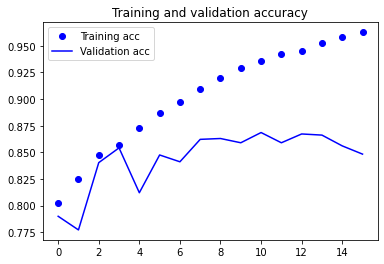

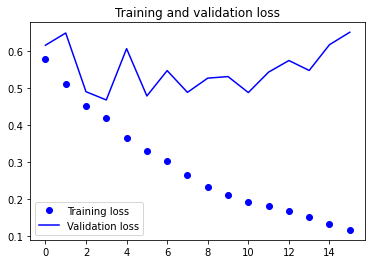

In [12]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
results = model.evaluate(test_generator)

470/470 [==============================] - 75s 159ms/step - loss: 0.6611 - categorical_accuracy: 0.8416


In [26]:
preds = np.argmax(model.predict(test_generator), axis = -1)

In [27]:
print(confusion_matrix(test_generator.classes,preds))

[[486   1   0   0   0   0   0   0   3   0]
 [  4 358  44   0   0   0   1   0  62  11]
 [  0   6 425   0   9   2   0   0  12   6]
 [  0   0   0 378   1  27  17  15  29   7]
 [  0   2  16   0 418  15   4   3   6   7]
 [  0   0   4   8  15 400   2   7   1   0]
 [ 11   0   0   2   0   9 163   1   8   4]
 [  0   0   0   9   2  47   0 156   2   0]
 [ 17   5   6  15   4  10   8   8 312  25]
 [  5   0   3   1   0   1   6   0  39  65]]


In [28]:
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes,preds,target_names = target_names))

              precision    recall  f1-score   support

           F       0.93      0.99      0.96       490
           G       0.96      0.75      0.84       480
           H       0.85      0.92      0.89       460
           I       0.92      0.80      0.85       474
           J       0.93      0.89      0.91       471
           K       0.78      0.92      0.84       437
           L       0.81      0.82      0.82       198
           M       0.82      0.72      0.77       216
           N       0.66      0.76      0.71       410
           O       0.52      0.54      0.53       120

    accuracy                           0.84      3756
   macro avg       0.82      0.81      0.81      3756
weighted avg       0.85      0.84      0.84      3756



# Building Model 2

While the results of the previous model were strong, I did it in multiple sessions, and so did not have the full history for presentation purposes. Plus, it is nice to verify the results with a second run.

In [5]:
model2 = models.Sequential()
model2.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(540, 490, 1)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2),padding = 'same'))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2),padding = 'same'))
model2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2),padding = 'same'))
model2.add(layers.Conv2D(512, (3, 3), activation='relu'))
model2.add(layers.Conv2D(512, (3, 3), activation='relu'))
model2.add(layers.Conv2D(512, (3, 3), activation='relu'))
model2.add(layers.Conv2D(512, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2),padding = 'same'))
model2.add(layers.Conv2D(512, (3, 3), activation='relu'))
model2.add(layers.Conv2D(512, (3, 3), activation='relu'))
model2.add(layers.Conv2D(512, (3, 3), activation='relu'))
model2.add(layers.Conv2D(512, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2),padding = 'same'))
model2.add(layers.Flatten())
model2.add(layers.Dense(1000, activation='relu'))
model2.add(layers.Dense(200, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))

In [6]:
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=.0001),
              metrics=['categorical_accuracy'])

In [8]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 538, 488, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 536, 486, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 268, 243, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 266, 241, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 264, 239, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 132, 120, 128)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 130, 118, 256)     2

In [9]:
callbacks = [
    ModelCheckpoint(
        filepath='.\SavedModels\iterCNN2',
        save_best_only=True,
        monitor="val_accuracy",
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy', 
        factor=0.1, 
        patience=3,
        min_delta=.01,
        cooldown = 3
    ),
    EarlyStopping(
    monitor="val_accuracy",
    min_delta=.01,
    patience=6,
    restore_best_weights=True
    )
]

In [10]:
history = model2.fit(train_generator,
                        steps_per_epoch= 30041//batch_size,
                        epochs=20,
                        validation_data=val_generator,
                        validation_steps= 3756//batch_size,
                        callbacks = callbacks
                    )

Epoch 1/20
3755/3755 [==============================] - 1573s 419ms/step - loss: 1.6909 - categorical_accuracy: 0.3684 - val_loss: 1.4106 - val_categorical_accuracy: 0.4907
Epoch 2/20
3755/3755 [==============================] - 1583s 422ms/step - loss: 1.3823 - categorical_accuracy: 0.4899 - val_loss: 1.2304 - val_categorical_accuracy: 0.5336
Epoch 3/20
3755/3755 [==============================] - 1594s 424ms/step - loss: 1.1981 - categorical_accuracy: 0.5628 - val_loss: 1.2286 - val_categorical_accuracy: 0.5458
Epoch 4/20
3755/3755 [==============================] - 1599s 426ms/step - loss: 1.0088 - categorical_accuracy: 0.6334 - val_loss: 0.9065 - val_categorical_accuracy: 0.6810
Epoch 5/20
3755/3755 [==============================] - 1591s 424ms/step - loss: 0.8519 - categorical_accuracy: 0.6899 - val_loss: 0.7759 - val_categorical_accuracy: 0.7071
Epoch 6/20
3755/3755 [==============================] - 1594s 425ms/step - loss: 0.7559 - categorical_accuracy: 0.7257 - val_loss: 0.73

Oops.. probably should have watched an iteration before going to bed, as I messed up the callbacks. It would be nice to have those working and observe their effect, but I do not have another night prior to my review to train the model again. At any rate, the results are satisfactory and I trained for enough iterations to see a plateau in the validation accuracy and stopped before too much overfitting occured.

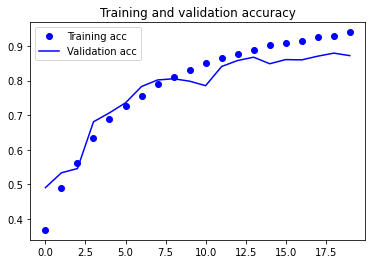

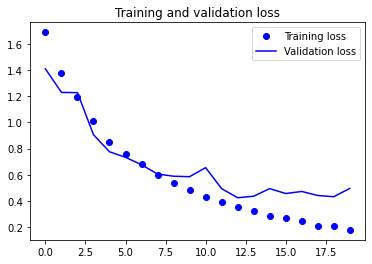

In [11]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [13]:
results = model2.evaluate(test_generator)

470/470 [==============================] - 65s 139ms/step - loss: 0.5734 - categorical_accuracy: 0.8637


In [14]:
preds = np.argmax(model2.predict(test_generator), axis = -1)

In [15]:
print(confusion_matrix(test_generator.classes,preds))

[[489   0   0   0   0   0   1   0   0   0]
 [  4 455  12   0   1   0   2   0   3   3]
 [  0  38 387   3  24   0   0   2   3   3]
 [  0   1   0 445   4   5   3   7   5   4]
 [  0   4   3   2 450   6   0   4   0   2]
 [  0   0   0   7  35 384   2   9   0   0]
 [  8   0   0  11   0   5 162   0   6   6]
 [  0   0   0  19   2  12   0 182   1   0]
 [ 33  24   4  41  14   1  11  11 211  60]
 [  5   1   3   6   8   1   5   0  12  79]]


In [16]:
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes,preds,target_names = target_names))

              precision    recall  f1-score   support

           F       0.91      1.00      0.95       490
           G       0.87      0.95      0.91       480
           H       0.95      0.84      0.89       460
           I       0.83      0.94      0.88       474
           J       0.84      0.96      0.89       471
           K       0.93      0.88      0.90       437
           L       0.87      0.82      0.84       198
           M       0.85      0.84      0.84       216
           N       0.88      0.51      0.65       410
           O       0.50      0.66      0.57       120

    accuracy                           0.86      3756
   macro avg       0.84      0.84      0.83      3756
weighted avg       0.87      0.86      0.86      3756



It is interesting to note that in the case of both models, the model struggled significantly with the final two categories; N, Atmospheric Front, and O, Oceanic Front. According to the paper presenting this dataset of labeled images, 'Periodic signatures of ocean waves can coexist with [both] Ocean Front [and] Atmospheric Front." Additionally, we can note from the confusion matrix that both were frequently misclassified in all the other categories, suggesting that these two phenomena are challenging to distinguish and may often have other phenomena or patterns similar to them within their labeled images. Finally, there is a noted dataset imbalance, where Ocean Fronts are especially underrepresented. In the future, data augmentation could be attempted to shore up the detriment to accuracy resulting from misidentification of this category.

# Prepping some visuals for presentation

In [6]:
model = models.load_model('.\SavedModels\iterCNN')

In [7]:
preds = np.argmax(model.predict(test_generator), axis = -1)

In [10]:
target_names = list(test_generator.class_indices.keys())
report = classification_report(test_generator.classes,preds,target_names = target_names,output_dict = True)

In [30]:
class_df = pd.DataFrame(report).transpose()
class_df = class_df.iloc[:10,:]
class_df = class_df.reset_index()
category_dict = {
    'F' : 'Pure Ocean Waves',
    'G' : 'Wind Streaks',
    'H' : 'Micro Convective Cells',
    'I' : 'Rain Cells',
    'J' : 'Biological Slicks',
    'K' : 'Sea Ice',
    'L' : 'Iceberg',
    'M' : 'Low Wind Area',
    'N' : 'Atmospheric Front',
    'O' : 'Oceanic Front'
}
class_df = class_df.rename(columns = {'index':'categories'})
class_df['categories'] = class_df.categories.apply(lambda x: x.replace(x,category_dict[x]))
class_df['f1-score'] = [0.95, 0.91, 0.89, 0.88, 0.89, 0.90, 0.84, 0.84, 0.65, 0.57]

In [31]:
class_df

,categories,precision,recall,f1-score,support
0,Pure Ocean Waves,0.929254,0.991837,0.95,490.0
1,Wind Streaks,0.962366,0.745833,0.91,480.0
2,Micro Convective Cells,0.853414,0.923913,0.89,460.0
3,Rain Cells,0.915254,0.797468,0.88,474.0
4,Biological Slicks,0.930958,0.887473,0.89,471.0
5,Sea Ice,0.782779,0.915332,0.90,437.0
6,Iceberg,0.810945,0.823232,0.84,198.0
7,Low Wind Area,0.821053,0.722222,0.84,216.0
8,Atmospheric Front,0.658228,0.760976,0.65,410.0
9,Oceanic Front,0.520000,0.541667,0.57,120.0


<AxesSubplot:xlabel='f1-score', ylabel='categories'>

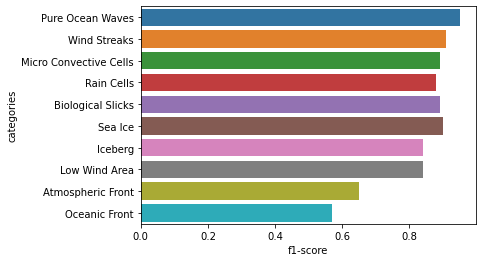

In [32]:
sns.barplot(data = class_df,x ='f1-score',y='categories')

In [60]:
conf_matrix = np.array([[489 ,  0 ,  0 ,  0 ,  0  , 0 ,  1  , 0 ,  0  , 0],
 [  4 ,455 , 12  , 0  , 1  , 0  , 2  , 0  , 3  , 3],
 [  0  ,38, 387,   3 , 24 ,  0 ,  0  , 2  , 3  , 3],
 [  0  , 1 ,  0 ,445 ,  4  , 5 ,  3  , 7 ,  5  , 4],
 [  0  , 4 ,  3 ,  2 ,450  , 6  , 0  , 4  , 0  , 2],
 [  0  , 0 ,  0 ,  7 , 35 ,384  , 2  , 9  , 0  , 0],
 [  8  , 0 ,  0 , 11 ,  0  , 5 ,162  , 0  , 6  , 6],
 [  0  , 0 ,  0 , 19 ,  2  ,12 ,  0 ,182  , 1 ,  0],
 [ 33  ,24 ,  4 , 41 , 14  , 1 , 11 , 11 ,211 , 60],
 [  5  , 1 ,  3 ,  6 ,  8 ,  1  , 5 ,  0 , 12 , 79]])
conf_matrix.shape

(10, 10)

In [67]:
scaled_conf = preprocessing.minmax_scale(conf_matrix.T).T
scaled_conf

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00204499, 0.        , 0.        , 0.        ],
       [0.00879121, 1.        , 0.02637363, 0.        , 0.0021978 ,
        0.        , 0.0043956 , 0.        , 0.00659341, 0.00659341],
       [0.        , 0.09819121, 1.        , 0.00775194, 0.0620155 ,
        0.        , 0.        , 0.00516796, 0.00775194, 0.00775194],
       [0.        , 0.00224719, 0.        , 1.        , 0.00898876,
        0.01123596, 0.00674157, 0.01573034, 0.01123596, 0.00898876],
       [0.        , 0.00888889, 0.00666667, 0.00444444, 1.        ,
        0.01333333, 0.        , 0.00888889, 0.        , 0.00444444],
       [0.        , 0.        , 0.        , 0.01822917, 0.09114583,
        1.        , 0.00520833, 0.0234375 , 0.        , 0.        ],
       [0.04938272, 0.        , 0.        , 0.06790123, 0.        ,
        0.0308642 , 1.        , 0.        , 0.03703704, 0.03703704],
       [0.        , 0.        , 0.       

<AxesSubplot:>

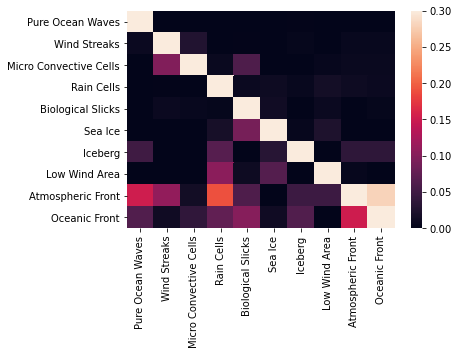

In [72]:
ticklabels = class_df.categories 
sns.heatmap(scaled_conf,vmin = 0,vmax = 0.3, xticklabels = ticklabels, yticklabels = ticklabels)

# Appendix

Here is a function and bit of code I was using to test what I will call 'seeding'. I noticed while trying to train the MLP baseline that the success of its training seemed to be largely dependent on the initialized weights, getting radically different results each time a new model was initialized. When I did get new results, however, it became obvious within the first epoch. Thus, when I was not getting good results with a CNN, I was trying reinitialization and training for one epoch to try and search for a 'seed' that would yield a working network. I ended up realizing there was an issue with the images as they were preprocessed, so I never needed to come back to this, but I have kept the code here just in case.

In [5]:
def instantiate_model():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu',
                            input_shape=(540, 490, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2),padding = 'same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2),padding = 'same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2),padding = 'same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2),padding = 'same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2),padding = 'same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1000, activation='relu'))
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

In [6]:
best_acc = 0
for i in range(36):
    model = instantiate_model()
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=.0001),
              metrics=['acc'])
    history = model.fit(train_generator,
                        steps_per_epoch= 30041//batch_size,
                        epochs=1,
                        validation_data=val_generator,
                        validation_steps= 3756//batch_size,
                        verbose = 2)
    acc = history.history['acc'][-1]
    if best_acc < acc:
        best_acc = acc
        print(f'New best accuracy: {best_acc}')
        model.save('.\SavedModels\iterCNN', overwrite = True)
    del model
    del history
    tf.keras.backend.clear_session()
    for i in range (100):
        gc.collect()

6008/6008 - 1742s - loss: 2.2701 - acc: 0.1257 - val_loss: 2.2293 - val_acc: 0.1305
New best accuracy: 0.12571580708026886
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: .\SavedModels\iterCNN\assets
6008/6008 - 1753s - loss: 2.2670 - acc: 0.1302 - val_loss: 2.2303 - val_acc: 0.1278
New best accuracy: 0.13017712533473969
INFO:tensorflow:Assets written to: .\SavedModels\iterCNN\assets
6008/6008 - 1735s - loss: 2.2520 - acc: 0.1277 - val_loss: 2.2302 - val_acc: 0.1278
6008/6008 - 1733s - loss: 2.2573 - acc: 0.1234 - val_loss: 2.2306 - val_acc: 0.1305
6008/6008 - 1733s - loss: 2.2527 - acc: 0.1254 - val_loss: 2.2319 - val_acc: 0.1254
6008/6008 - 1737s - loss: 2.2578 - acc: 0.1273 - val_loss: 2.2318 - val_acc: 0.1278
6008/6008 - 1735s - loss: 2.2591 - acc: 0.1253 - val_los

KeyboardInterrupt: 